In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt

#### setting up 

In [38]:
# 1. SETUP PATHS
# This follows the 'processed' alias to your Local_Data
base_dir = os.path.abspath('../data/processed')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# 2. CONFIGURATION
IMG_SIZE = 150  # We force all images to this size: small enough but still detailed for our case
BATCH_SIZE = 32 # We feed 32 images at a time to the model: it's enough images to get a good "average" of what the data looks like.

print(f"Training on data from: {train_dir}")
print(f"Validating on data from: {val_dir}")

Training on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/train
Validating on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/val


### generators definition for proper training and evaluation

In [39]:
# 3. DEFINE GENERATORS

# Train: Augmentation enabled (Hard mode for learning)
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values (0-1)
    rotation_range=40,      # Twist up to 40 degrees
    width_shift_range=0.2,  # Move Left/Right 20%
    height_shift_range=0.2, # Move Up/Down 20%
    shear_range=0.2,        # Slant/Perspective distortion
    zoom_range=0.2,         # Zoom in/out 20%
    horizontal_flip=True,   # Mirror flip
    fill_mode='nearest'     # Fill gaps with neighbor color
)

# Validation;
val_datagen = ImageDataGenerator(rescale=1./255)

# 4. LOAD DATA
# flow_from_directory looks at the folder directory and extracts images (32) automatically assigning them the proper label given the 
# fact they belong to a certain subfolder (rock, paper or scissors)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Validation Data...")
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Loading Training Data...
Found 1531 images belonging to 3 classes.
Loading Validation Data...
Found 326 images belonging to 3 classes.


## Model specification

In [40]:
# 5. BUILD THE MODEL
model = models.Sequential([
    # Block 1: The Outline Detector (32 Filters)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    # Block 2: The Shape Detector (64 Filters)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Block 3: The Feature Detector (128 Filters)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Block 4: The Complex Pattern Detector (128 Filters)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten: Convert the 2D maps into a 1D list of numbers
    layers.Flatten(),
    
    # Dense: The Reasoning Layer
    layers.Dense(512, activation='relu'),
    
    # Output: The Answer (3 classes: Rock, Paper, Scissors)
    layers.Dense(3, activation='softmax') 
])

# Print a summary to check the architecture
model.summary()

/Users/paolominini/Projects/rps-cnn-classifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

This is a standard 4-Layer Convolutional Network.
- The "Funnel" Design (32 $\rightarrow$ 64 $\rightarrow$ 128 $\rightarrow$ 128):
    -   Layer 1 (32 Filters): This layer is shallow. It only looks for simple "edges" and "colors" (e.g., the line where a finger meets the background). We use fewer filters (32) because there are only so many ways to draw a line.
    - Layers 3 & 4 (128 Filters): Deeper layers combine those lines into complex shapes (fingers, knuckles, fists). We need more filters (128) here because the combinations are much more complex.
- MaxPooling2D(2, 2): After every learning layer, we cut the image size in half (150 $\rightarrow$ 75 $\rightarrow$ 37...).Reason: This forces the AI to summarize. It stops caring about exactly which pixel a finger is on and starts caring that there is a finger in that general area. It also massively reduces the math required, preventing your computer from "exploding."
- Dense(512): This is the "Classifier." After the visual features are extracted, these 512 neurons act like a committee that votes on what those features mean.
- Dense(3, activation='softmax'): This is the final output. It must be 3 because we have 3 classes. Softmax turns the raw math scores into probabilities (e.g., "90% Rock, 5% Paper, 5% Scissors").

In [41]:
# EarlyStopping: Stop if the model stops improving for 5 epochs (prevents wasting time)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: If the model gets stuck, lower the learning rate to help it find the "sweet spot"
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # Multiply LR by 0.2 (reduce it)
    patience=3,   # Wait 3 epochs before reducing
    min_lr=1e-6,
    verbose=1
)

In [42]:
# 6. COMPILE
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("Model compiled and ready for training.")

Model compiled and ready for training.


In [ ]:
# 7. TRAIN
print("Starting training...")

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training Complete!")

Starting training...
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 281ms/step - accuracy: 0.4252 - loss: 1.0730 - val_accuracy: 0.6871 - val_loss: 0.8360 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 293ms/step - accuracy: 0.6871 - loss: 0.7340 - val_accuracy: 0.9018 - val_loss: 0.3416 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step - accuracy: 0.7694 - loss: 0.5681 - val_accuracy: 0.9264 - val_loss: 0.2984 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 269ms/step - accuracy: 0.8001 - loss: 0.4892 - val_accuracy: 0.9110 - val_loss: 0.2930 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 275ms/step - accuracy: 0.8204 - loss: 0.4392 - val_accuracy: 0.9663 - val_loss: 0.1830 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.8406 - loss: 0.3866 - val_accuracy: 0.9325 - val_loss: 0.1835 - learning_rate: 0.0010
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - accura

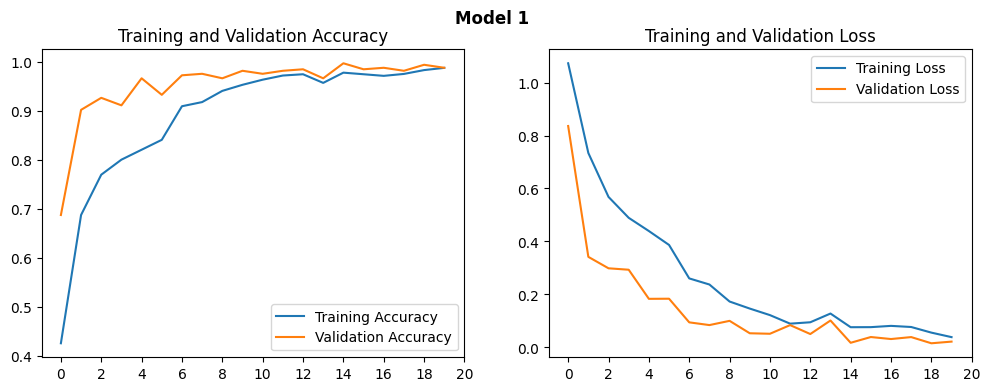

Graph saved to: /Users/paolominini/Projects/rps-cnn-classifier/reports/figures/training_history_1.png


In [ ]:
# 6. PLOT RESULTS OF TRAINING AND VALIDATION ACCURACY
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

# Graph 1: Accuracy (Higher is better)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xticks(range(0, len(epochs_range) + 1, 2))
plt.legend(loc='lower right')
plt.suptitle('Model 1', fontweight='bold')
plt.title('Training and Validation Accuracy')

# Graph 2: Loss (Lower is better)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xticks(range(0, len(epochs_range) + 1, 2))
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# 3. SAVE TO FILE
# save_path = os.path.abspath('../reports/figures/training_history_1.png')
# plt.savefig(save_path)
# plt.show()

# print(f"Graph saved to: {save_path}")

The consistent performance gap where Validation > Training confirms that the Data Augmentation pipeline successfully prevented overfitting, forcing the model to learn robust features rather than memorizing pixels.